# Index - Visualization

In [1]:
import seaborn as sns
import pandas
import geopandas as gpd
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import os
import mapclassify

import folium
import shapely
import math
from scipy.stats import normaltest, pearsonr, stats
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.impute import KNNImputer

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_FIGS = False
SAVE_TABLES = False

VARIABLE_TO_PREDICT =  "CCI"
AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

In [3]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [4]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

### Data

In [5]:
# Datasets 
INDEX_DATA = 'data/processed/CCI/03_index/CCI_Index.gpkg'
DEMOGRPAHIC_DATA = '/work/data/interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.gpkg'

## Parameter check

In [6]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/".format("CCI")
DIR_DEMOGRAPHIC = DIR_VAR + "11_demographic/{}/".format(AREA_TO_PREDICT)

if SAVE_FIGS:
    folder_list = [
        DIR_DEMOGRAPHIC,
        DIR_DEMOGRAPHIC + "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [7]:
PATH_TO_FILE = DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.gpkg"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
                'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

## Plot results of Index

In [8]:
# Read spatial dataset into GeoDataFrame
gdf = gpd.read_file(DEMOGRPAHIC_DATA) 

# Reset index to column
gdf.reset_index()

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    gdf = gdf[gdf["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    gdf = gdf[~gdf.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    gdf = gdf[~gdf.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    gdf = gdf[~gdf.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    gdf = gdf[~gdf.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    gdf = gdf[~gdf.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

# Redo index by CTOT
gdf.set_index("CTOT", inplace=True)

In [9]:
# Read spatial dataset into GeoDataFrame
CCI = gpd.read_file(INDEX_DATA) 

# Reset index to column
CCI.reset_index()

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    CCI = CCI[CCI["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    CCI = CCI[~CCI.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    CCI = CCI[~CCI.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    CCI = CCI[~CCI.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    CCI = CCI[~CCI.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    CCI = CCI[~CCI.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

# Redo index by CTOT
CCI.set_index("CTOT", inplace=True)

CCI = pd.merge(gdf, CCI[VARIABLE_TO_PREDICT], left_index=True, right_index=True)
CCI = CCI[[VARIABLE_TO_PREDICT, "geometry"]]

In [10]:
DEMOGRAPHIC_list = [
    'POPULATION_2020',
    "POPULATION_DENSITY_KM2_2020",
    "POPULATION_PERC_NATURAL_GROWTH_2020",
    #"GENDER_PERC_POP_MALE_2020",
    "GENDER_PERC_POP_FEMALE_2020",
    "AGE_AVERAGE_2020",
    "AGE_PERC_POP_BELOW_18_2020",
    "AGE_PERC_POP_ABOVE_65_2020",   
    #"NATIONALITY_PERC_SPANISH_2020",
    "NATIONALITY_PERC_NONSPANISH_2020",    
]

SOCIOECONOMIC_list = [
    "HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020",
    "HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020",
    'HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011',
    "INCOME_PER_CAPITA_2020",
    "INCOME_PER_HOUSEHOLD_2020",
    'INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020',
]
   
ECONOMIC_list = [
    "WEALTH_GINI_2020",
    "DEBT_MUNICIPALITY_PER_CAPITA_2021",
    "ECONOMY_COMPANIES_PER_CAPITA_2020",
    'AGRI_LIVESTOCKUNITS_DENSITY_KM2_2020',
    'AGRI_CATTLEFARMS_DENSITY_KM2_2020',    
    'TOURISM_HOUSES_PER_CAPITA_2022',
]

## Descriptive Statistics

### All Features

In [11]:
# Description of all feature data
if SAVE_TABLES is True:
    gdf.describe().to_csv((DIR_DEMOGRAPHIC + "descriptive_all_features.csv"), index=True)

gdf.describe()

,POPULATION_2020,POPULATION_DENSITY_KM2_2020,POPULATION_PERC_NATURAL_GROWTH_2020,GENDER_PERC_POP_FEMALE_2020,AGE_AVERAGE_2020,AGE_PERC_POP_BELOW_18_2020,AGE_PERC_POP_ABOVE_65_2020,NATIONALITY_PERC_NONSPANISH_2020,HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020,HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020,HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011,INCOME_PER_CAPITA_2020,INCOME_PER_HOUSEHOLD_2020,INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020,WEALTH_GINI_2020,DEBT_MUNICIPALITY_PER_CAPITA_2021,ECONOMY_COMPANIES_PER_CAPITA_2020,AGRI_LIVESTOCKUNITS_DENSITY_KM2_2020,AGRI_CATTLEFARMS_DENSITY_KM2_2020,TOURISM_HOUSES_PER_CAPITA_2022
count,8.087000e+03,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,6519.000000,8079.000000,6289.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000
mean,5.764073e+03,194.883422,-1.263169,46.861298,49.853159,11.791802,29.129121,7.052949,2.276217,37.364189,1.554220,11682.653168,27986.309073,10.177974,23.100495,0.143149,1.531932,18.269456,0.389217,0.008433
std,4.707305e+04,1362.180084,1.652037,4.763342,6.904952,6.185416,11.066213,7.467689,0.351201,11.657643,0.939248,2259.459473,6533.086638,5.473394,11.880903,0.467146,63.506235,647.455750,14.193262,0.021708
min,3.000000e+00,0.188205,-35.000000,0.000000,33.300000,0.000000,0.000000,0.000000,1.140000,0.000000,0.473002,5898.000000,13646.000000,2.069902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.505000e+02,4.622183,-1.869159,45.032084,44.200000,6.900000,20.600000,2.000000,2.040000,28.700000,0.968521,10036.500000,23301.000000,6.785371,24.400000,0.000000,0.007034,0.000000,0.000000,0.000000
50%,5.170000e+02,13.254434,-0.873069,48.239896,49.200000,12.100000,27.700000,4.900000,2.290000,35.700000,1.299023,11469.000000,27134.000000,8.688699,27.700000,0.000000,0.049558,0.000000,0.000000,0.001005
75%,2.397000e+03,55.152765,-0.183055,49.912443,54.900000,16.700000,36.500000,9.800000,2.520000,44.500000,1.813324,13046.000000,31031.500000,11.633110,30.100000,0.092389,0.202859,8.684075,0.163278,0.007168
max,3.240998e+06,80922.608649,8.823529,75.806452,75.400000,34.800000,80.000000,87.700000,7.000000,90.000000,17.000000,26367.000000,83377.000000,47.372430,44.400000,15.176998,5637.543860,42367.583150,995.243136,0.571429


In [12]:
# Preprocess data
X = gdf.drop(columns=['geometry'])
X['CCI'] = CCI['CCI']
imputer = KNNImputer()
X_transformed = imputer.fit_transform(X)
X = pd.DataFrame(X_transformed, columns=X.columns)

# Calculate Bivariate Regression Correlations of CCI with each feature
correlation_matrix = X.corr()

# Calculate p-values
p_values = []
for col in correlation_matrix.columns:
    _, p = stats.pearsonr(X[col], X['CCI'])
    p_values.append(p)

# Add p-values to the correlation matrix
correlation_matrix.loc['p-value'] = p_values
print(correlation_matrix)

if SAVE_TABLES is True:
    correlation_matrix['CCI'].to_csv((DIR_DEMOGRAPHIC + "bivariate_correlations_CCI_all_features.csv"), index=True)

correlation_matrix

                                                    POPULATION_2020   
POPULATION_2020                                        1.000000e+00  \
POPULATION_DENSITY_KM2_2020                            2.051928e-01   
POPULATION_PERC_NATURAL_GROWTH_2020                    6.948157e-02   
GENDER_PERC_POP_FEMALE_2020                            1.054415e-01   
AGE_AVERAGE_2020                                      -1.165893e-01   
AGE_PERC_POP_BELOW_18_2020                             1.076791e-01   
AGE_PERC_POP_ABOVE_65_2020                            -1.059026e-01   
NATIONALITY_PERC_NONSPANISH_2020                       7.202915e-02   
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020                    9.943506e-02   
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020              -9.977250e-02   
HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011            -8.198448e-02   
INCOME_PER_CAPITA_2020                                 4.018568e-02   
INCOME_PER_HOUSEHOLD_2020                              9.015354e-02   
INCOME

,POPULATION_2020,POPULATION_DENSITY_KM2_2020,POPULATION_PERC_NATURAL_GROWTH_2020,GENDER_PERC_POP_FEMALE_2020,AGE_AVERAGE_2020,AGE_PERC_POP_BELOW_18_2020,AGE_PERC_POP_ABOVE_65_2020,NATIONALITY_PERC_NONSPANISH_2020,HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020,HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020,...,INCOME_PER_CAPITA_2020,INCOME_PER_HOUSEHOLD_2020,INCOME_PERC_UNEMPLOYMENT_BENEFITS_OF_AVERAGE_SALARY_2020,WEALTH_GINI_2020,DEBT_MUNICIPALITY_PER_CAPITA_2021,ECONOMY_COMPANIES_PER_CAPITA_2020,AGRI_LIVESTOCKUNITS_DENSITY_KM2_2020,AGRI_CATTLEFARMS_DENSITY_KM2_2020,TOURISM_HOUSES_PER_CAPITA_2022,CCI
POPULATION_2020,1.000000e+00,2.051928e-01,6.948157e-02,0.105441,-0.116589,0.107679,-0.105903,7.202915e-02,0.099435,-0.099772,...,4.018568e-02,9.015354e-02,-9.971968e-03,8.261420e-02,5.820507e-02,0.778922,-0.001194,-0.000464,-0.009900,0.174909
POPULATION_DENSITY_KM2_2020,2.051928e-01,1.000000e+00,8.304310e-02,0.113312,-0.139362,0.136260,-0.127062,6.106297e-02,0.128540,-0.133851,...,4.075740e-02,1.104115e-01,-2.326496e-02,6.374015e-02,3.040769e-02,0.051179,0.350730,0.352072,-0.023763,0.153959
POPULATION_PERC_NATURAL_GROWTH_2020,6.948157e-02,8.304310e-02,1.000000e+00,0.178188,-0.530843,0.495112,-0.497951,2.003784e-01,0.404891,-0.378537,...,6.008231e-03,2.295162e-01,5.592148e-02,2.117536e-01,1.901203e-02,0.012784,0.000786,0.001973,0.033368,0.316307
GENDER_PERC_POP_FEMALE_2020,1.054415e-01,1.133115e-01,1.781877e-01,1.000000,-0.451868,0.489677,-0.368826,1.099931e-01,0.440791,-0.516491,...,-1.965377e-01,7.100895e-02,1.570520e-01,4.395115e-01,7.188538e-02,0.025048,0.016601,0.018422,-0.045488,0.430830
AGE_AVERAGE_2020,-1.165893e-01,-1.393625e-01,-5.308431e-01,-0.451868,1.000000,-0.936199,0.958511,-3.453060e-01,-0.746427,0.710014,...,7.484522e-02,-3.428036e-01,-1.182112e-01,-4.504666e-01,-1.071805e-01,-0.022928,-0.000730,-0.002042,-0.010510,-0.546250
AGE_PERC_POP_BELOW_18_2020,1.076791e-01,1.362601e-01,4.951116e-01,0.489677,-0.936199,1.000000,-0.846851,3.200196e-01,0.734394,-0.703223,...,-5.314733e-02,3.655716e-01,7.026568e-02,4.253950e-01,1.058626e-01,0.020258,0.002102,0.003645,-0.010089,0.535816
AGE_PERC_POP_ABOVE_65_2020,-1.059026e-01,-1.270620e-01,-4.979510e-01,-0.368826,0.958511,-0.846851,1.000000,-3.147700e-01,-0.687482,0.637505,...,3.865339e-02,-3.363040e-01,-1.071224e-01,-3.979689e-01,-9.737103e-02,-0.020937,0.000281,-0.000779,-0.035457,-0.492631
NATIONALITY_PERC_NONSPANISH_2020,7.202915e-02,6.106297e-02,2.003784e-01,0.109993,-0.345306,0.320020,-0.314770,1.000000e+00,0.253804,-0.223523,...,-9.125449e-02,6.947894e-02,3.591574e-02,2.389955e-01,4.682882e-02,0.019860,-0.013117,-0.014182,0.172159,0.267327
HOUSING_AVERAGE_HOUSEHOLD_SIZE_2020,9.943506e-02,1.285400e-01,4.048909e-01,0.440791,-0.746427,0.734394,-0.687482,2.538044e-01,1.000000,-0.905143,...,2.608103e-02,5.101085e-01,-5.664989e-02,3.243104e-01,5.173544e-02,0.017632,0.013037,0.014240,-0.093586,0.445930
HOUSING_PERC_SINGLEPERSON_HOUSEHOLD_2020,-9.977250e-02,-1.338506e-01,-3.785371e-01,-0.516491,0.710014,-0.703223,0.637505,-2.235228e-01,-0.905143,1.000000,...,6.090644e-02,-4.045346e-01,-1.419112e-02,-3.924192e-01,-4.583505e-02,-0.016502,-0.013808,-0.015379,0.141393,-0.479888


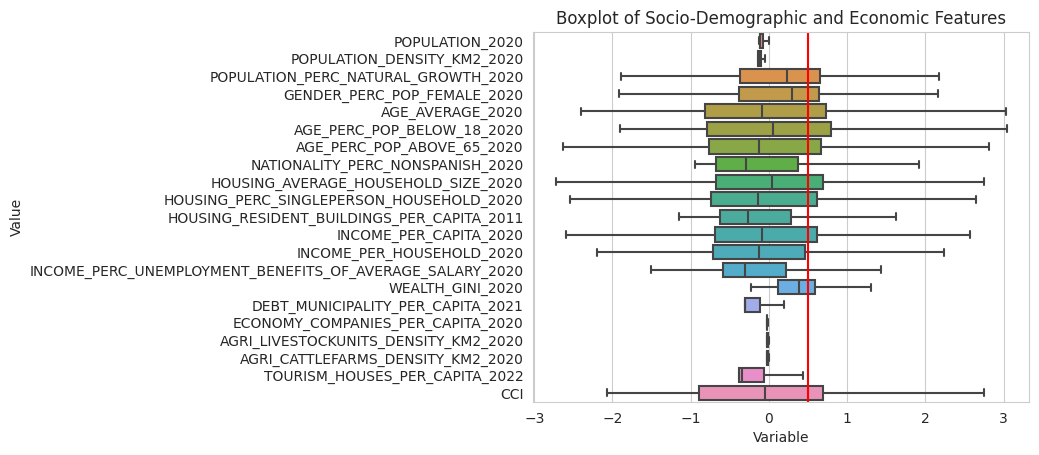

In [13]:
# Boxplot of all feature data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_normalized = pd.DataFrame(data=X_normalized, columns=X.columns)

sns.set_style('whitegrid')
sns.boxplot(
    x="value", 
    y="variable",
    showfliers = False, 
    data=pd.melt(X_normalized)
    ).set(
        title='Boxplot of Socio-Demographic and Economic Features',
        xlabel='Variable', 
        ylabel='Value'
        )

# Add vertical line
plt.axvline(x=0.5, color='r')

if SAVE_FIGS is True:
    plt.savefig(DIR_DEMOGRAPHIC + "boxplot_all_features.svg", format="svg")

plt.show()

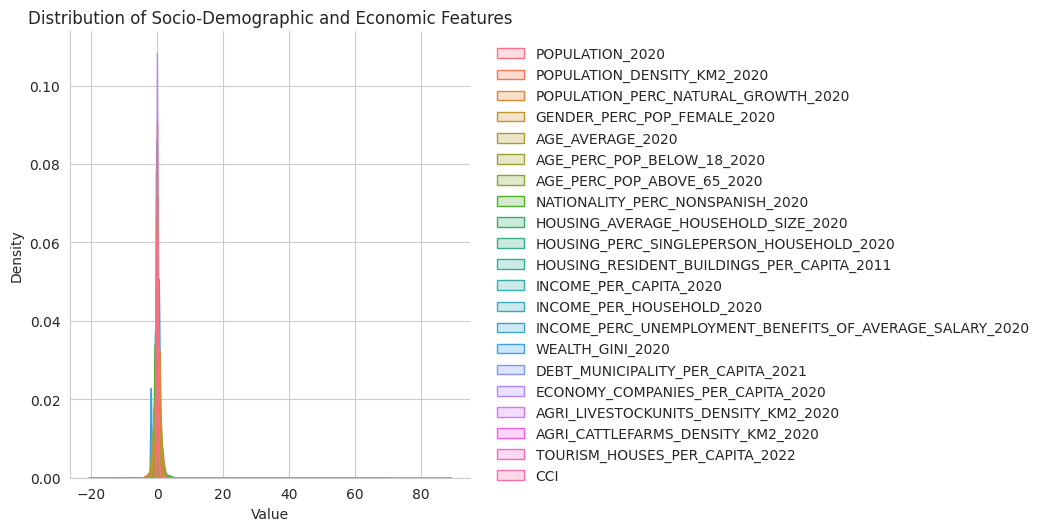

In [14]:
# Distribution of all feature data
fig = sns.displot(
    data=X_normalized, 
    kind="kde",
    fill=True).set(
        title='Distribution of Socio-Demographic and Economic Features', 
        xlabel='Value', 
        ylabel='Density'
        )

if SAVE_FIGS is True:
    plt.savefig(DIR_DEMOGRAPHIC + "distribution_all_features.svg", format="svg")

### Best Model Features

In [15]:
# Load best model dataset from 07_linear notebook
linear_coefs = pd.read_csv("data/processed/CCI/Spain/07_linear/coefficients.csv", index_col=0)
best_model = linear_coefs.drop(["Intercept"], axis=1).columns

# Use best model in geodataframe
gdf_best_model = gdf[best_model]
gdf_best_model['geometry'] = gdf['geometry']

print(best_model)

Index(['POPULATION_2020', 'INCOME_PER_HOUSEHOLD_2020', 'WEALTH_GINI_2020',
       'HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011',
       'AGRI_CATTLEFARMS_DENSITY_KM2_2020', 'GENDER_PERC_POP_FEMALE_2020',
       'TOURISM_HOUSES_PER_CAPITA_2022', 'NATIONALITY_PERC_NONSPANISH_2020',
       'DEBT_MUNICIPALITY_PER_CAPITA_2021', 'AGE_AVERAGE_2020',
       'ECONOMY_COMPANIES_PER_CAPITA_2020'],
      dtype='object')


In [16]:
# Description of all feature data
if SAVE_TABLES is True:
    gdf_best_model.describe().to_csv((DIR_DEMOGRAPHIC + "descriptive_selected_features.csv"), index=True)

gdf_best_model.describe()

,POPULATION_2020,INCOME_PER_HOUSEHOLD_2020,WEALTH_GINI_2020,HOUSING_RESIDENT_BUILDINGS_PER_CAPITA_2011,AGRI_CATTLEFARMS_DENSITY_KM2_2020,GENDER_PERC_POP_FEMALE_2020,TOURISM_HOUSES_PER_CAPITA_2022,NATIONALITY_PERC_NONSPANISH_2020,DEBT_MUNICIPALITY_PER_CAPITA_2021,AGE_AVERAGE_2020,ECONOMY_COMPANIES_PER_CAPITA_2020
count,8.087000e+03,8079.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000,8087.000000
mean,5.764073e+03,27986.309073,23.100495,1.554220,0.389217,46.861298,0.008433,7.052949,0.143149,49.853159,1.531932
std,4.707305e+04,6533.086638,11.880903,0.939248,14.193262,4.763342,0.021708,7.467689,0.467146,6.904952,63.506235
min,3.000000e+00,13646.000000,0.000000,0.473002,0.000000,0.000000,0.000000,0.000000,0.000000,33.300000,0.000000
25%,1.505000e+02,23301.000000,24.400000,0.968521,0.000000,45.032084,0.000000,2.000000,0.000000,44.200000,0.007034
50%,5.170000e+02,27134.000000,27.700000,1.299023,0.000000,48.239896,0.001005,4.900000,0.000000,49.200000,0.049558
75%,2.397000e+03,31031.500000,30.100000,1.813324,0.163278,49.912443,0.007168,9.800000,0.092389,54.900000,0.202859
max,3.240998e+06,83377.000000,44.400000,17.000000,995.243136,75.806452,0.571429,87.700000,15.176998,75.400000,5637.543860


In [17]:
# Boxplot of all feature data
sns.set_style('whitegrid')
sns.boxplot(
    x="value", 
    y="variable", 
    data=pd.melt(gdf_best_model)
    ).set(
        title='Boxplot of Socio-Demographic and Economic Features',
        xlabel='Variable', 
        ylabel='Value'
        )

# Add vertical line
plt.axvline(x=0.5, color='r')

if SAVE_FIGS is True:
    plt.savefig(DIR_DEMOGRAPHIC + "boxplot_selected_features.svg", format="svg")

plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

In [0]:
# Distirbution of all feature data
fig = sns.displot(
    data=gdf_best_model, 
    kind="kde", 
    fill=True).set(
        title='Distribution of Socio-Demographic and Economic Features', 
        xlabel='Value', 
        ylabel='Density'
        )

if SAVE_FIGS is True:
    plt.savefig(DIR_DEMOGRAPHIC + "distribution_selected_features.svg", format="svg")

## Mapping (Visualization)

In [0]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = 'face'
    else: color = "black"
    return color

# Define scheme type
def scheme_type(variable):
    if variable.startswith("PERC_"): scheme =  'naturalbreaks'
    else: scheme = "naturalbreaks"
    return scheme

# Define map color type
def map_color(variable):
    if variable.startswith("PERC_"): color =  'coolwarm'
    else: color = "Blues" #YlOrBr
    return color

### All Features

In [0]:
cluster_variables = list(gdf)[:-1]
nrows_clusters = math.ceil(len(cluster_variables) / 3)

f, axs = plt.subplots(nrows=nrows_clusters, ncols=3, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        edgecolor=line_color(AREA_TO_PREDICT),
        scheme=scheme_type(col),
        linewidth=0,
        cmap=map_color(col),
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col, fontsize=8)

if SAVE_FIGS:
    plt.savefig(DIR_DEMOGRAPHIC + "map_all_features.svg", format="svg")

plt.tight_layout()

# Display the figure
plt.show()

### Beste Model Features

In [0]:
cluster_variables = list(gdf_best_model)[:-1]
nrows_clusters = math.ceil(len(cluster_variables) / 3)

f, axs = plt.subplots(nrows=nrows_clusters, ncols=3, figsize=(12, 12))

# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf_best_model.plot(
        column=col,
        ax=ax,
        edgecolor=line_color(AREA_TO_PREDICT),
        scheme=scheme_type(col),
        linewidth=0,
        cmap=map_color(col),
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col, fontsize=8)

if SAVE_FIGS:
    plt.savefig(DIR_DEMOGRAPHIC + "map_selected_features.svg", format="svg")

plt.tight_layout()

# Display the figure
plt.show()

### Total Index

In [0]:
# Plot results 
for col in gdf.columns:
    if col in DEMOGRAPHIC_list:
        fig, ax = plt.subplots(figsize=(20, 20))

        gdf.plot(
            ax=ax,
            column=col,
            edgecolor=line_color(AREA_TO_PREDICT),
            legend=True,
            figsize=(20, 20),
            #legend_kwds={"shrink": 0.7},
            scheme=scheme_type(col),            
            cmap=map_color(col)
        )

        ax.set_title("Demographic feature: {} - {}".format(col, AREA_TO_PREDICT), fontsize=20, y=1.01)

        if SAVE_FIGS is True:
            plt.savefig(DIR_DEMOGRAPHIC + "{}_{}".format(col, AREA_TO_PREDICT) + ".svg", format="svg")

        plt.show()
    else: 
        pass

In [0]:
# Plot results 
for col in gdf.columns:
    if col in SOCIOECONOMIC_list:
        fig, ax = plt.subplots(figsize=(20, 20))

        gdf.plot(
            ax=ax,
            column=col,
            edgecolor=line_color(AREA_TO_PREDICT),
            legend=True,
            figsize=(20, 20),
            cmap=map_color(col),
            #legend_kwds={"shrink": 0.7},
            scheme=scheme_type(col),
        )

        ax.set_title("Socio-Economic feature: {} - {}".format(col, AREA_TO_PREDICT), fontsize=20, y=1.01)

        if SAVE_FIGS is True:
            plt.savefig(DIR_DEMOGRAPHIC + "{}_{}".format(col, AREA_TO_PREDICT) + ".svg", format="svg")

        plt.show()
    else: 
        pass

In [0]:
# Plot results 
for col in gdf.columns:
    if col in ECONOMIC_list:
        fig, ax = plt.subplots(figsize=(20, 20))

        gdf.plot(
            ax=ax,
            column=col,
            edgecolor=line_color(AREA_TO_PREDICT),
            legend=True,
            figsize=(20, 20),
            cmap=map_color(col),
            #legend_kwds={"shrink": 0.7},
            scheme=scheme_type(col),
        )

        ax.set_title("Economic feature: {} - {}".format(col, AREA_TO_PREDICT), fontsize=20, y=1.01)

        if SAVE_FIGS is True:
            plt.savefig(DIR_DEMOGRAPHIC + "{}_{}".format(col, AREA_TO_PREDICT) + ".svg", format="svg")

        plt.show()
    else: 
        pass

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>